In [1]:
import Pkg
Pkg.activate("../../")

  Activating project at `C:\SY\MIT\UROP\InverseGraphics\InverseGraphics`


In [158]:
# ENV["PYTHON"] = "C:\\Users\\karen\\Miniconda3\\envs\\inversegraphics_env\\python.exe"
# Pkg.build("PyCall")
# Pkg.precompile()

In [3]:
import Revise
import GLRenderer as GL
import Images as I
import MiniGSG as S
import Rotations as R
import PoseComposition: Pose, IDENTITY_POSE, IDENTITY_ORN
import InverseGraphics as T
import NearestNeighbors
import LightGraphs as LG
import StaticArrays
import ProgressMeter
using Distributions
import Gen
using Plots
using ProgressMeter
try
    import MeshCatViz as V
catch
    import MeshCatViz as V    
end

In [4]:
# # Initialize the renderer
# V.setup_visualizer()

In [63]:
# Loading the YCB object models
YCB_DIR = joinpath(dirname(dirname(pwd())),"data")
world_scaling_factor = 10.0
id_to_cloud, id_to_shift, id_to_box  = T.load_ycbv_models_adjusted(YCB_DIR, world_scaling_factor);
all_ids = sort(collect(keys(id_to_cloud)));
names = T.load_ycb_model_list(YCB_DIR)

21-element Vector{String}:
 "002_master_chef_can"
 "003_cracker_box"
 "004_sugar_box"
 "005_tomato_soup_can"
 "006_mustard_bottle"
 "007_tuna_fish_can"
 "008_pudding_box"
 "009_gelatin_box"
 "010_potted_meat_can"
 "011_banana"
 "019_pitcher_base"
 "021_bleach_cleanser"
 "024_bowl"
 "025_mug"
 "035_power_drill"
 "036_wood_block"
 "037_scissors"
 "040_large_marker"
 "051_large_clamp"
 "052_extra_large_clamp"
 "061_foam_brick"

In [64]:
# Initialize the canera intrinsics and renderer that will render using those intrinsics.
camera = GL.CameraIntrinsics()
renderer = GL.setup_renderer(camera, GL.DepthMode())
resolution = 0.05
for id in all_ids
    cloud = id_to_cloud[id]
    mesh = GL.mesh_from_voxelized_cloud(GL.voxelize(cloud, resolution), resolution);
    GL.load_object!(renderer, mesh)
end
@show camera;

gl_version_for_shaders = "410"
true
camera = GLRenderer.CameraIntrinsics
  width: Int64 640
  height: Int64 480
  fx: Float64 640.0
  fy: Float64 640.0
  cx: Float64 320.0
  cy: Float64 240.0
  near: Float64 0.001
  far: Float64 100.0



In [7]:
object_id = 15
pose = Pose([0.0, 0.0, 5.0], R.RotXYZ(0.1, 0.2, -0.4))
camera_pose = IDENTITY_POSE
# Render object of type object_id at the specified pose viewed from a camera at camera_pose.
gt_depth_image = GL.gl_render(renderer, [object_id], [pose], camera_pose);

In [8]:
# # Create point cloud corresponding to that rendered depth image.
# c = GL.depth_image_to_point_cloud(gt_depth_image, camera)
# # Visualize that point cloud.
# V.viz(c)
# GL.view_depth_image(gt_depth_image)

In [55]:
# One way to do coarsen is to scale down the resolution of the rendered image

# Here we scale down the camera by a factor of 6.
scaled_camera = GL.scale_down_camera(camera, 6)
print(scaled_camera)

# Set the renderer to now have those scaled down intrinsics.
GL.set_intrinsics!(renderer, scaled_camera)

# And render the same image as above.
gt_depth_image = GL.gl_render(renderer, [object_id], [pose], camera_pose)
print(size(gt_depth_image))


# Remember to revert the intrinsics inside of the renderer.
GL.set_intrinsics!(renderer, camera)

# Create point cloud corresponding to that rendered depth image.
c = GL.depth_image_to_point_cloud(gt_depth_image, scaled_camera)
print(size(c))


GLRenderer.CameraIntrinsics
  width: Int64 107
  height: Int64 80
  fx: Float64 106.66666666666667
  fy: Float64 106.66666666666667
  cx: Float64 53.333333333333336
  cy: Float64 40.0
  near: Float64 0.001
  far: Float64 100.0
true
(80, 107)true
(3, 923)

In [10]:
# # Visualize that point cloud.
# V.viz(c)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))
# img = GL.view_depth_image(gt_depth_image)
# img = I.imresize(img, (camera.height, camera.width))

In [11]:
# Let's see how resolution effects the rendering speed

GL.set_intrinsics!(renderer, camera)
@time gt_depth_image = GL.gl_render(renderer, [object_id], [pose], camera_pose)

# Set the renderer to now have those scaled down intrinsics.
GL.set_intrinsics!(renderer, scaled_camera)
# And render the same image as above.
@time gt_depth_image = GL.gl_render(renderer, [object_id], [pose], camera_pose)

# Remember to revert the intrinsics inside of the renderer.
GL.set_intrinsics!(renderer, camera)

true
  0.004783 seconds (92 allocations: 8.208 MiB)
true
  0.001105 seconds (92 allocations: 239.016 KiB)
true


In [12]:
# Sketch of the structure of a simplified single object 3DP3 generative model.
@gen function single_object_model(resolution)
    i ~ categorical(1:21)
    p ~ T.uniformPose(-10,10,-10,10,-10,10) 
    rendered_d = GL.gl_render(renderer, [i], [p], IDENTITY_POSE)
    cloud_inliers = GL.depth_image_to_point_cloud(rendered_d, camera) 
    d ~ T.uniform_mixture_from_template(
        cloud_inliers, 0.0001, resolution,
    (-100.0, 100.0, -100.0, 100.0,-100.0,100.0))
end

LoadError: LoadError: UndefVarError: @gen not defined
in expression starting at In[12]:2

In [13]:
# Below, I show how this likelihood is computed between two point clouds (the latent and observed clouds).
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,100.0)
score_clouds(obs_cloud, latent_cloud, resolution) = Gen.logpdf(
    T.uniform_mixture_from_template,
    obs_cloud, latent_cloud, 0.0001, resolution, bounds)



score_clouds (generic function with 1 method)

In [14]:
# Two randomly generated point clouds.
c = rand(3,10000) * 10.0;
c2 = rand(3,10000) * 10.0;

In [15]:
@show score_clouds(c, c2, 0.1)
@show score_clouds(c, c2, 5.0)  # coarsen can "improve" likelihood
@show score_clouds(c, c, 0.1)  # higher likelihood

score_clouds(c, c2, 0.1) = -248750.3926606152
score_clouds(c, c2, 5.0) = -83053.8814655096
score_clouds(c, c, 0.1) = -44015.56714786968


-44015.56714786968

In [16]:
# Lets see how likelihood changes with the size of the spheres.
@time score_clouds(c, c2, 0.1) 
@time score_clouds(c, c2, 2.0)

  0.004686 seconds (30.45 k allocations: 2.254 MiB)
  0.120486 seconds (68.75 k allocations: 89.258 MiB)


-78808.09483690344

In [17]:
# Also to make nice visualizations, you can rendering RGB mode!

In [18]:
# renderer = GL.setup_renderer(camera, GL.RGBMode())
# obj_paths = T.load_ycb_model_obj_file_paths(YCB_DIR)
# for id in all_ids
#     mesh = GL.get_mesh_data_from_obj_file(obj_paths[id])
#     mesh = T.scale_and_shift_mesh(mesh, world_scaling_factor, id_to_shift[id])
#     GL.load_object!(renderer, mesh)
# end

# Intro demo of coarse-to-fine with particle filtering

In [19]:
## pick some obj / pose to test
i = 4
pose = Pose([0.0, 0.0, 5.0], R.RotXYZ(0.6, -0.2, -0.4))

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.9257544967612822, x=0.30713052585829886, y=-0.03505587323819195, z=-0.21776257154014744)⟩

## introductory visualizations
to get a better sense of resolution effect on likelihood + qualitative results 

scale down by 1.0
true


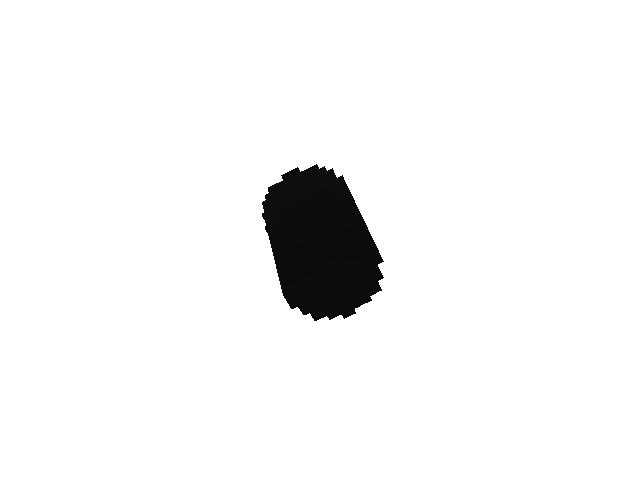

true
scale down by 4.0
true


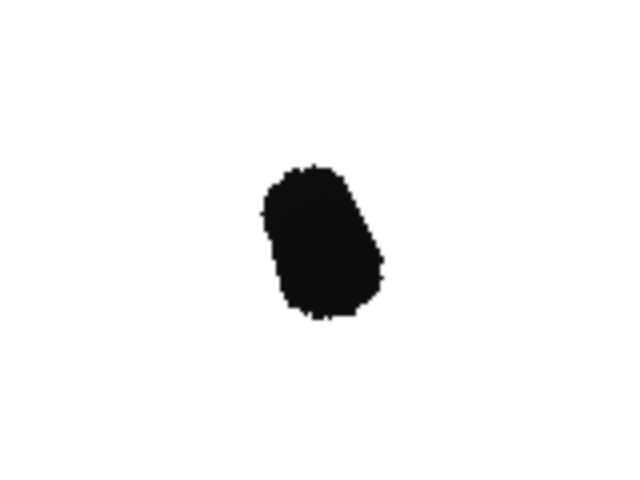

true
scale down by 7.0
true


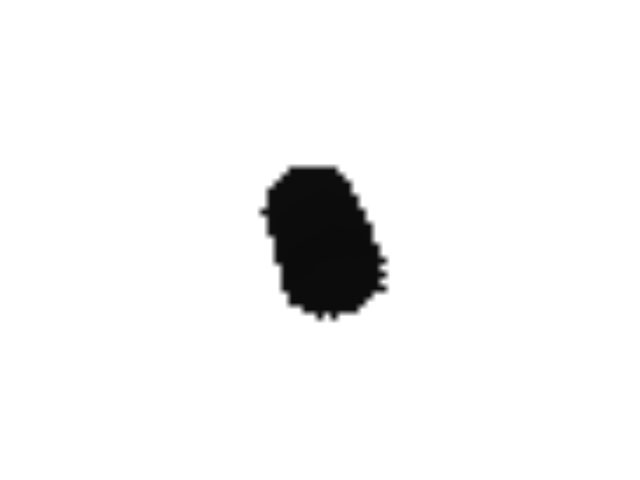

true
scale down by 10.0
true


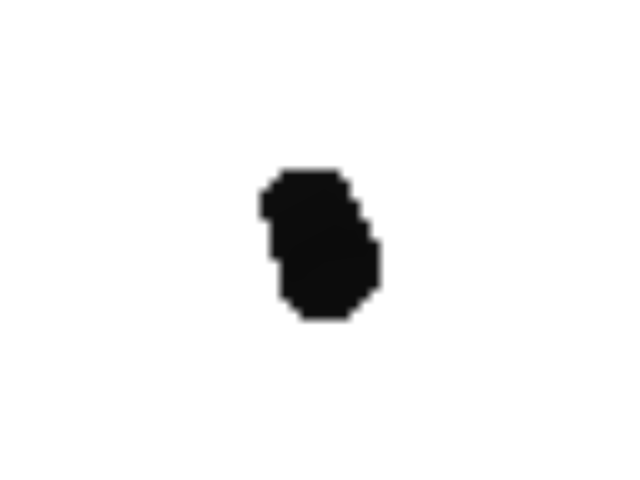

true
scale down by 13.0
true


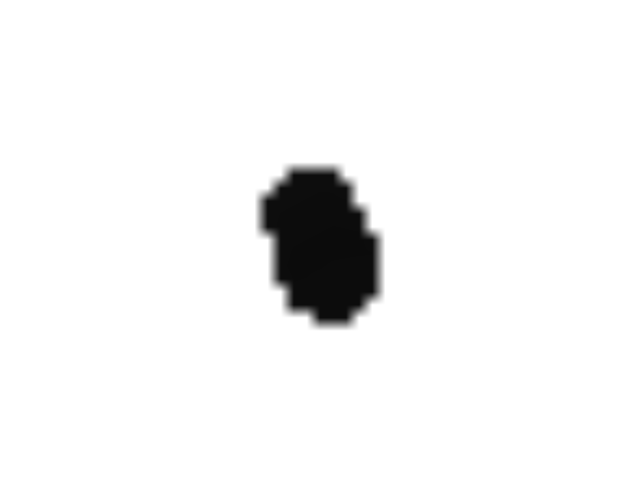

true
scale down by 16.0
true


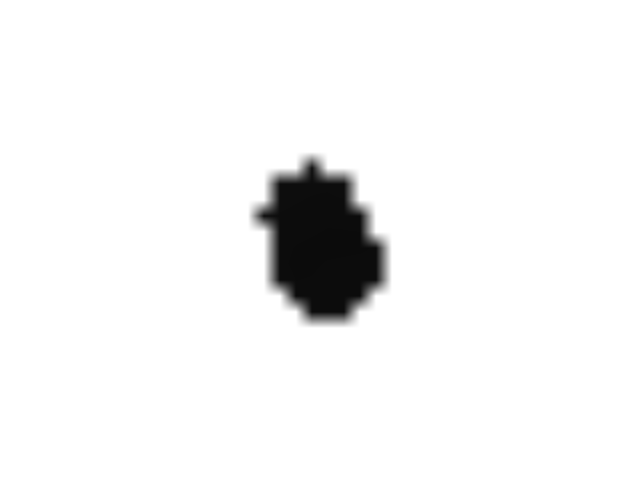

true
scale down by 19.0
true


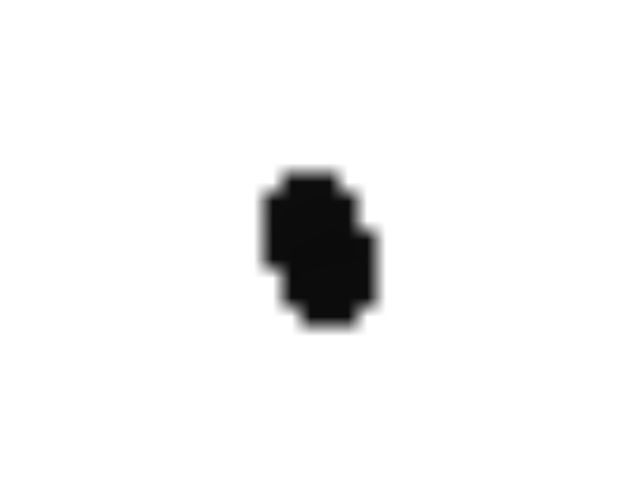

true
scale down by 22.0
true


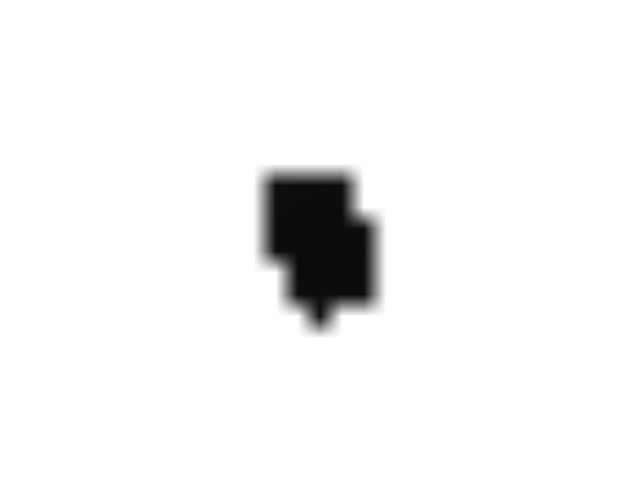

true


In [20]:
########
# camera downscaling
########
using IJulia

final = 24
for downscale_factor=1:3.0:final
    println("scale down by $downscale_factor")
    
    # scale camera according to resolution; reset renderer
    scaled_camera = GL.scale_down_camera(camera, downscale_factor)
        
    # Set the renderer to now have those scaled down intrinsics.
    GL.set_intrinsics!(renderer, scaled_camera)
 
    d = GL.gl_render(renderer, [i], [pose], IDENTITY_POSE)

    img = GL.view_depth_image(d)
    img = I.imresize(img, (camera.height, camera.width));
    IJulia.display(img)
  
    # revert intrinsics
    GL.set_intrinsics!(renderer, camera)

end


true


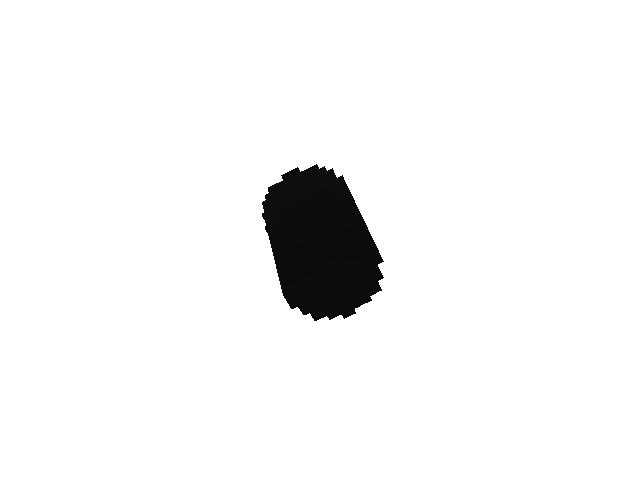

i = 4


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8704
└ @ MeshCat C:\Users\karen\.julia\packages\MeshCat\Ax8pH\src\visualizer.jl:73


3×9313 Matrix{Float64}:
  0.219406   3.44035  -2.50768  -6.84692  …   5.32369  1.70701    5.9159
 -0.51418    1.20199   1.07296  -4.41164     -1.80044  0.307496  -3.63765
  4.89239   11.5152    6.91074   2.50345      2.8665   4.64787    4.34035

In [21]:
#########
# radius scaling
#########
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,100.0)


# Reset the intrinsics inside of the renderer.
GL.set_intrinsics!(renderer, camera) 

# And render the same image as above.
gt_depth_image = GL.gl_render(renderer, [i], [pose], IDENTITY_POSE)
IJulia.display(GL.view_depth_image(gt_depth_image))

# Create point cloud corresponding to that rendered depth image.
gt_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera)
# print(size(gt_cloud))


@show i

radius = 0.01  # "tight" radius
sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# Visualize that point cloud.
V.setup_visualizer()
V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

 
radius = float(1)  # "loose" radius (can still pick out general shape)
sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# Visualize that point cloud.
V.setup_visualizer()
V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

 
radius = float(10)  # very loose radius; points on a sphere (w/ some concentration on center with shape of obj)
sampled_cloud = Gen.random(T.uniform_mixture_from_template, gt_cloud, 0.0001, radius, bounds)
# # Visualize that point cloud.
# V.setup_visualizer()
# V.viz(sampled_cloud)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))

## Particle Filtering + Orientation enumeration

Get angles to enumerate over

In [22]:
function fibonacci_sphere(samples)
    points = []
    phi = π * (3. - sqrt(5.))
 
    for i in 0:(samples-1)
        y = 1 - (i / Float64(samples - 1)) * 2
        @show y
        radius = sqrt(1 - y * y)

        theta = phi * i

        x = cos(theta) * radius
        z = sin(theta) * radius

        push!(points, (x, y, z))
    end
    return points
end

fibonacci_sphere (generic function with 1 method)

In [165]:
unit_sphere_directions = fibonacci_sphere(100)#fibonacci_sphere(200);
other_rotation_angle = collect(0:0.2:(2*π));


y = 1.0
y = 0.9797979797979798
y = 0.9595959595959596
y = 0.9393939393939394
y = 0.9191919191919192
y = 0.898989898989899
y = 0.8787878787878788
y = 0.8585858585858586
y = 0.8383838383838383
y = 0.8181818181818181
y = 0.797979797979798
y = 0.7777777777777778
y = 0.7575757575757576
y = 0.7373737373737373
y = 0.7171717171717171
y = 0.696969696969697
y = 0.6767676767676767
y = 0.6565656565656566
y = 0.6363636363636364
y = 0.6161616161616161
y = 0.595959595959596
y = 0.5757575757575757
y = 0.5555555555555556
y = 0.5353535353535354
y = 0.5151515151515151
y = 0.4949494949494949
y = 0.4747474747474747
y = 0.4545454545454546
y = 0.43434343434343436
y = 0.41414141414141414
y = 0.3939393939393939
y = 0.3737373737373737
y = 0.3535353535353535
y = 0.33333333333333337
y = 0.31313131313131315
y = 0.29292929292929293
y = 0.2727272727272727
y = 0.2525252525252525
y = 0.23232323232323238
y = 0.21212121212121215
y = 0.19191919191919193
y = 0.1717171717171717
y = 0.1515151515151515
y = 0.1313131313131312

In [164]:
@show rotations_to_enumerate_over = [
    let
        T.geodesicHopf_select_axis(StaticArrays.SVector(dir), ang, 1)
    end
    for dir in unit_sphere_directions, 
        ang in other_rotation_angle
]
num_rotations_to_enumerate_over = length(rotations_to_enumerate_over)

Excessive output truncated after 1163941 bytes.

rotations_to_enumerate_over = [let
        #= In[164]:3 =#
        T.geodesicHopf_select_axis(StaticArrays.SVector(dir), ang, 1)
    end for dir = unit_sphere_directions, ang = other_rotation_angle] = 

6400

In [24]:
# traces = (orn -> Gen.generate(model, args,
#         Gen.choicemap(T.obs_addr() => gt_cloud,
#         :id => gt_trace[:id],
#         T.floating_pose_addr(1) => Pose([0.0, 0.0, 5.0], orn)))).(rotations_to_enumerate_over);
# scores = (i -> i[2]).(traces);

# log_weights = [i[2] for i in traces];
# log_weights = log_weights .- Gen.logsumexp(log_weights);
# weights = exp.(log_weights)
# best_trace, _ = traces[argmax(weights)];
# viz_trace(best_trace);
# sort(weights[:])

true
Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.7071067811865476, x=0.0, y=0.0, z=0.7071067811865475)⟩

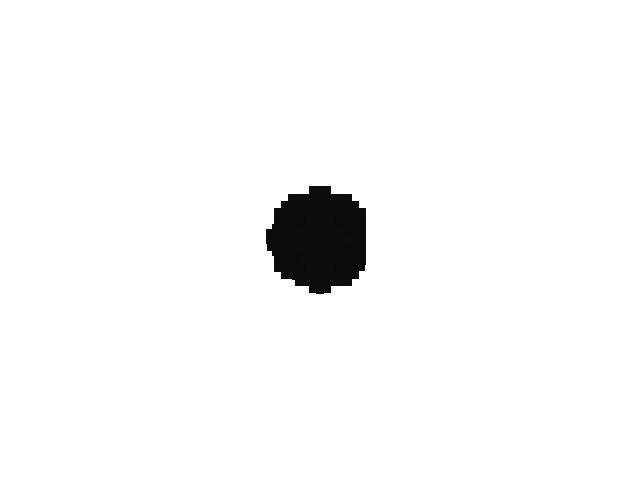

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.6692240319403541, x=0.0, y=-0.07137187461300806, z=0.7396250743368028)⟩

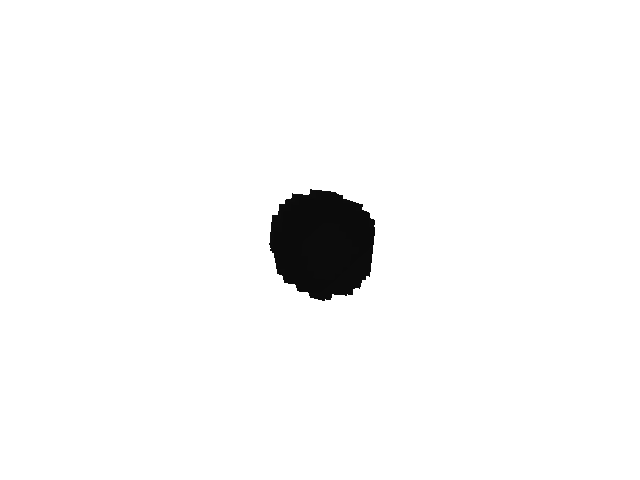

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.7132463510020844, x=0.0, y=0.13931227630781293, z=0.6869292048327448)⟩

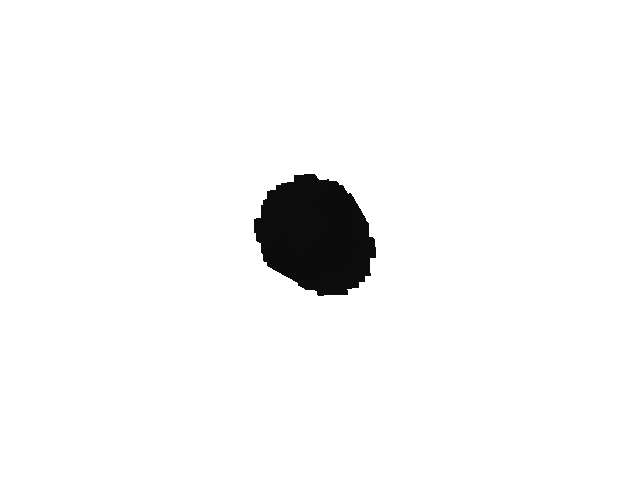

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.7577202593259571, x=0.0, y=-0.12762294370665705, z=0.6399784315480106)⟩

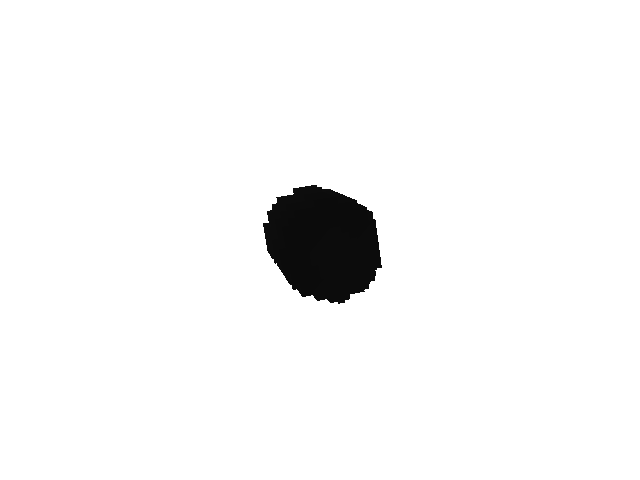

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.6014991699281986, x=0.0, y=0.04064080874864923, z=0.7978390020799583)⟩

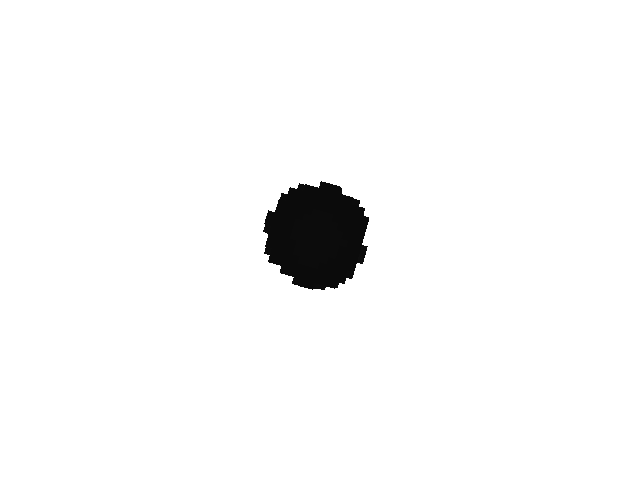

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.7950178068113878, x=0.0, y=0.10565990827729538, z=0.5973128749957132)⟩

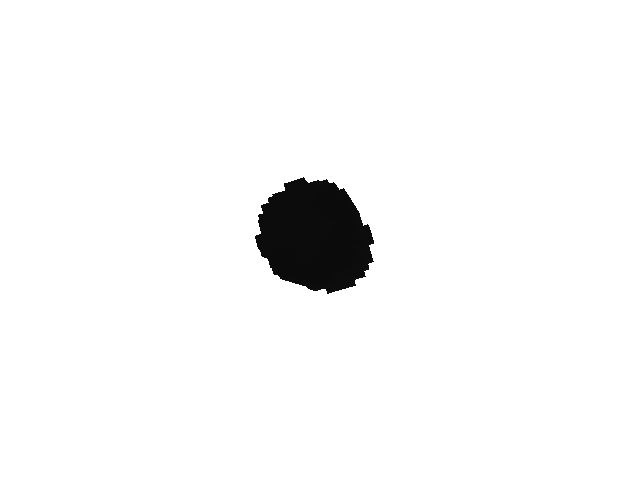

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.674986772668764, x=0.0, y=-0.24465548208012514, z=0.6960865979246748)⟩

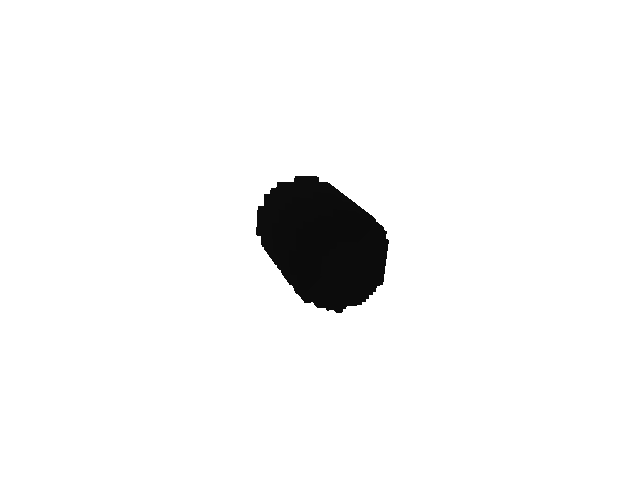

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.6442746276361055, x=0.0, y=0.25375736407866273, z=0.7214689212711844)⟩

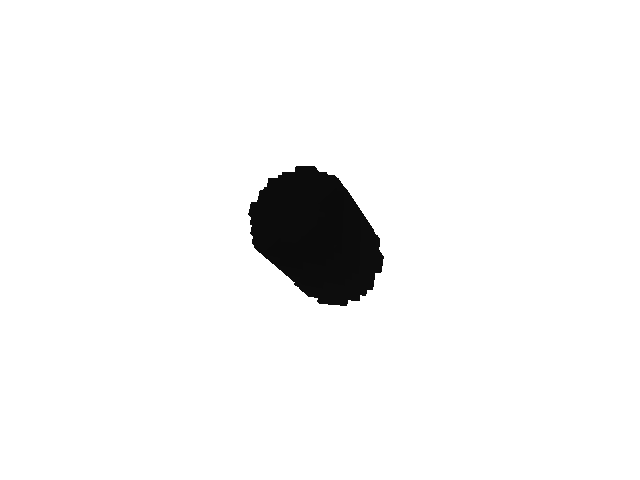

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.8273519295611297, x=0.0, y=-0.08144442226678245, z=0.5557477761836799)⟩

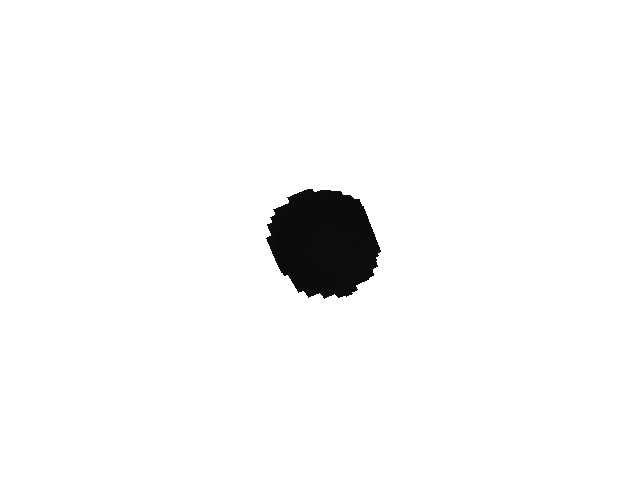

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.5549065174167958, x=0.0, y=-0.14288410055739853, z=0.8195504198865782)⟩

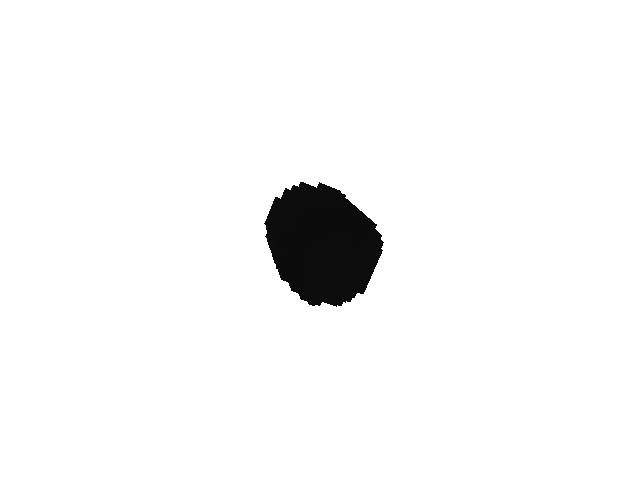

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.7698016973319283, x=0.0, y=0.2570394379447899, z=0.584239740282967)⟩

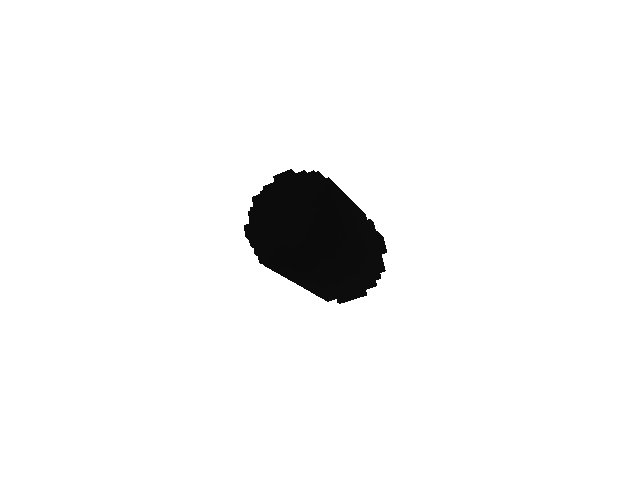

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.7539177872111106, x=0.0, y=-0.28921531232231756, z=0.5898834403888678)⟩

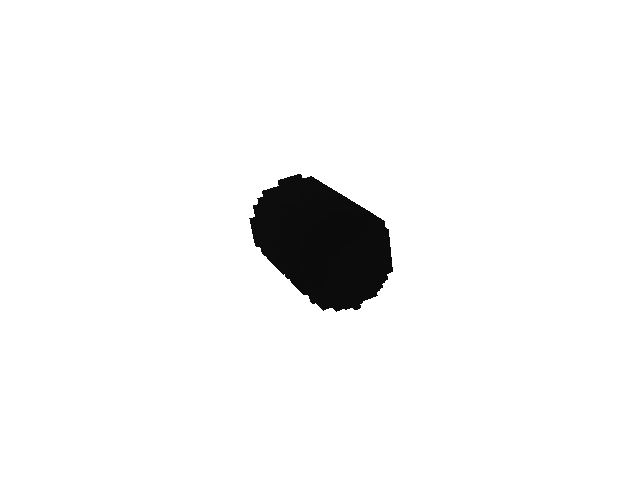

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.5422556003768882, x=0.0, y=0.22011275012320675, z=0.8108694352934382)⟩

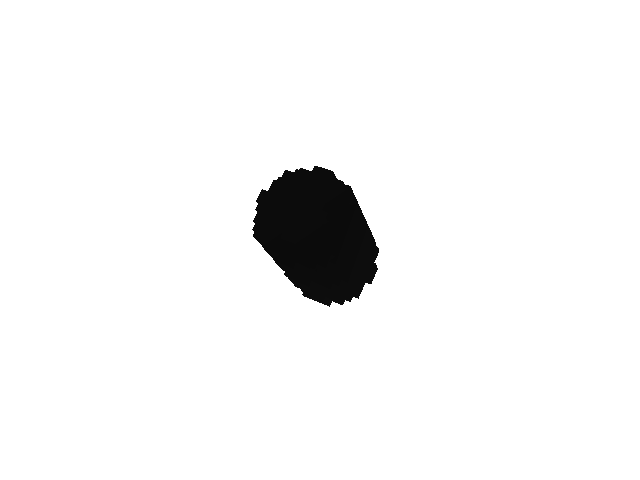

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.8610098004500132, x=0.0, y=0.061622359128148195, z=0.5048413695256262)⟩

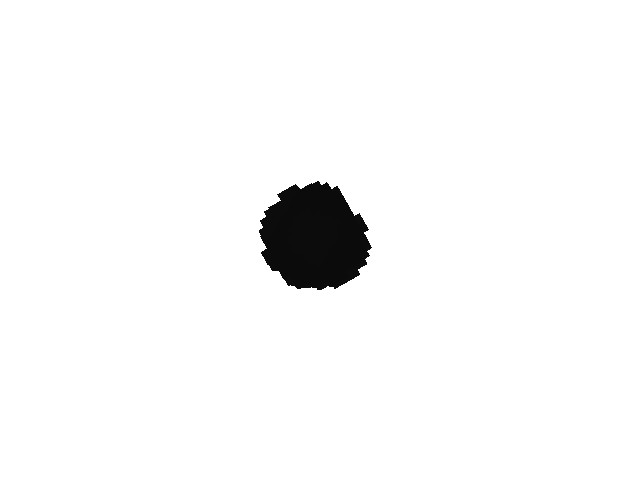

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.5940682015552042, x=0.0, y=-0.35216561272659025, z=0.7232304979146486)⟩

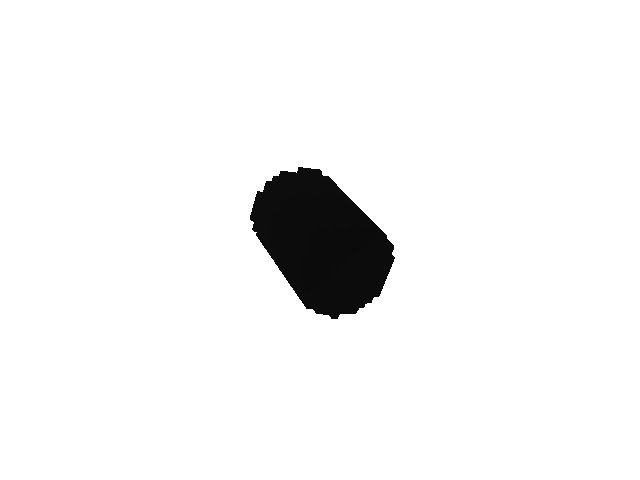

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.6826956644375012, x=0.0, y=0.38349366189431167, z=0.6219800969847268)⟩

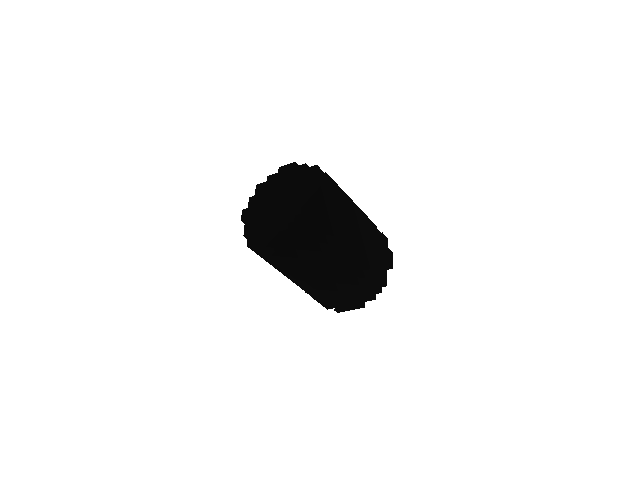

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.8413793398897746, x=0.0, y=-0.20827052456735182, z=0.49870251152674894)⟩

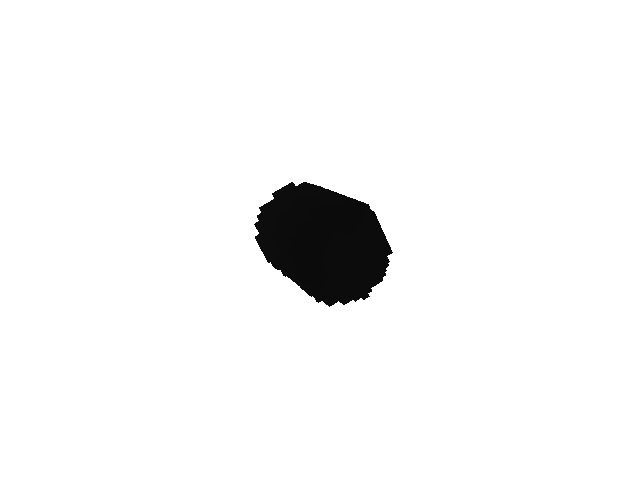

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.4698110585996009, x=0.0, y=-0.024582231687169644, z=0.8824246614316719)⟩

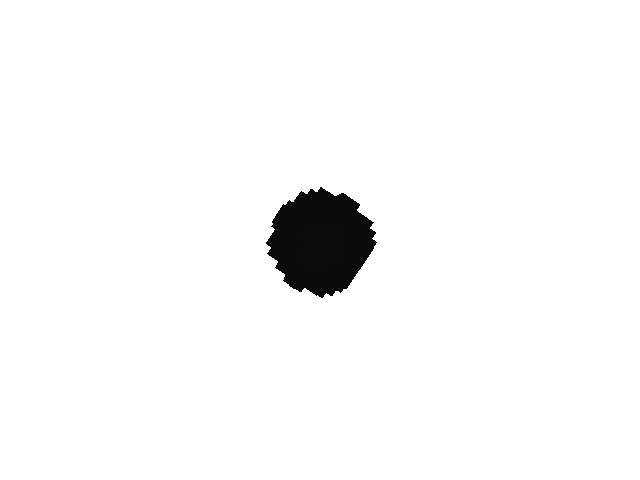

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.8386373193628197, x=0.0, y=0.24125225670986422, z=0.48834905058200095)⟩

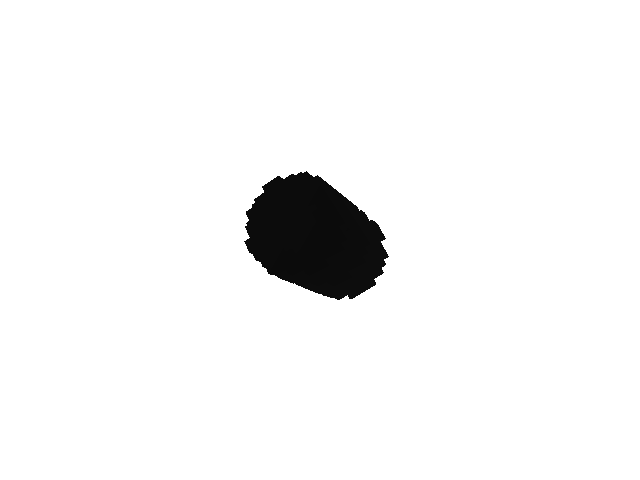

Pose⟨pos=[0.0, 0.0, 5.0], orientation=(w=0.6974421640097413, x=0.0, y=-0.4209087618152762, z=0.5800088293194682)⟩

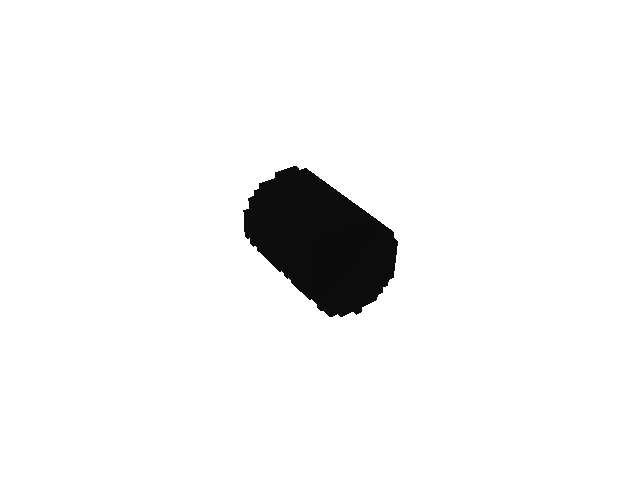

In [25]:
GL.set_intrinsics!(renderer, camera)

for idx=1:20
    pose_ = Pose([0.0, 0.0, 5.0], rotations_to_enumerate_over[idx])
    print(pose_)
    d = GL.gl_render(renderer, [i], [pose_], IDENTITY_POSE)
    img = GL.view_depth_image(d)
    IJulia.display(img)
end

### Helpers

In [93]:
function viz_trace(trace)
    V.setup_visualizer()
#     V.reset_visualizer()
    V.viz(Gen.get_retval(trace).voxelized_cloud  ./ 10.0; color=I.colorant"red", channel_name=:gen);
    V.viz(Gen.get_retval(trace).obs_cloud ./ 10.0; color=I.colorant"blue", channel_name=:obs);
end

viz_trace (generic function with 1 method)

In [174]:
"""adapted from gen pf_step:
Perform a particle filter update, where the model arguments are adjusted, new observations are added, and the default proposal is used for new latent state.
"""
function particle_filter_step!(state::Gen.ParticleFilterState{U}, new_args::Tuple, argdiffs::Tuple,
        observations_func::Function) where {U}    
    
    log_incremental_weights = Vector{Float64}(undef, num_particles) 
    radius::Float64 = new_args[1]
    @showprogress for i=1:num_particles
        # TODO? do mh, drift moves, etc. tune particle before update (i.e. new likelihood)
        #
        #
        
        # construct observations 
        particle_ori = Gen.get_retval(state.traces[i]).ori
#         observations = observations_func(particle_ori)
        observations = observations_func()
         
        
        # evolve the particle (with new radius involved in new_args)
        (state.new_traces[i], increment, _, discard) = Gen.update(
            state.traces[i], new_args, argdiffs, observations)
#         if !isempty(discard)
#             error("Choices were updated or deleted inside particle filter step: $discard")
#         end
        log_incremental_weights[i] = increment
        state.log_weights[i] += increment
    end
    
    # swap references
    tmp = state.traces
    state.traces = state.new_traces
    state.new_traces = tmp

    return (log_incremental_weights,)
end

particle_filter_step!

In [179]:
bounds = (-100.0, 100.0, -100.0, 100.0,-100.0,300.0)
v_resolution = 0.05   # distance between two points on the pointcloud 

"""sample point clouds at the given camera resolution and radius"""
Gen.@gen function model(radius, renderer, renderer_camera)
    num_candidate_objs = 6
    
    # fixed object (TODO: generalize to any obj id) and pose
    i = {:id} ~ Gen.categorical(fill(1.0/num_candidate_objs, (num_candidate_objs,)))
    p = {T.floating_pose_addr(1)} ~ T.uniformPose(-0.001, 0.001, -0.001, 0.001, 4.999, 5.001)
    
    
    rendered_depth = GL.gl_render(renderer, [i], [p], IDENTITY_POSE)
    gt_cloud = GL.depth_image_to_point_cloud(rendered_depth, renderer_camera)
    voxelized_cloud = GL.voxelize(gt_cloud, v_resolution)
    obs_cloud = {:obs => :cloud} ~ T.uniform_mixture_from_template(voxelized_cloud, 0.0001, radius, bounds)
#     print("."); flush(stdout)
         
    (id=i, pose=p, ori=p.orientation, cloud=gt_cloud, voxelized_cloud=voxelized_cloud, obs_cloud=obs_cloud)

end
 
"""return scale down factor of camera given desired resolution"""
function scale_factor(resolution, final_resolution)
   return final_resolution-resolution+1 
end

scale_factor

In [180]:
"""Selecting from a set of traces over all enumerated angles, generate a set of initial particles"""
Gen.@gen function generate_initial_pf_state(scored_traces, num_particles, plotdist=true)
    traces = (t -> t[1]).(scored_traces)
    log_weights = (t -> t[2]).(scored_traces) #; log_weights = log_weights .- Gen.logsumexp(log_weights)  # ∝ likelihood
    
    selected_traces = Vector{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}}(undef, num_particles)
    selected_log_weights = Vector{Float64}(undef, num_particles)
    for i=1:num_particles
        trace_idx = {:t_idx => i} ~ Gen.categorical(log_weights)   
        selected_traces[i] = traces[i]
        selected_log_weights[i] = log_weights[i]
    end
    
    println("Initial particle state computed")
    # visualize pdf of initial weights
    plot(selected_log_weights, seriestype=:stephist, size=(600,200))
    flush(stdout)
    
    return Gen.ParticleFilterState{U}(selected_traces, Vector{U}(undef, num_particles), selected_log_weights, 0., collect(1:num_particles))

end

generate_initial_pf_state

### control resolution with radius (fixed camera intrinsics)

In [181]:
"""Particle filter on the evolution of agent knowledge over time; resolution control with radius"""


function particle_filter(renderer, camera::GL.CameraIntrinsics, init_radius::Float64, final_radius::Float64,
                        gt_obj_id::Int, gt_pose::Pose, num_particles::Int, num_samples::Int, U=Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}})
    
    # initialize renderer and particle filter
    GL.set_intrinsics!(renderer, camera) 
    gt_depth_image = GL.gl_render(renderer, [gt_object_id], [gt_pose], IDENTITY_POSE)
    gt_cloud = GL.depth_image_to_point_cloud(gt_depth_image, camera)
    gt_voxelized_cloud = GL.voxelize(gt_cloud, v_resolution)
    
    println("\ninitializing particle filter at radius $init_radius") 
    flush(stdout)
    
    
    # initialize a state of initial particles with various rotations
    get_init_observations(orientation) =
                Gen.choicemap(
                            (:obs => :cloud) => gt_voxelized_cloud,
                            :id => gt_obj_id,
                            T.floating_pose_addr(1) => Pose(gt_pose.pos, orientation)
                            )
    get_observations() =
                Gen.choicemap(
                            (:obs => :cloud) => gt_voxelized_cloud,
                            :id => gt_obj_id,
                            )
    
    orn_stepsize = num_rotations_to_enumerate_over ÷ num_particles
    args = (init_radius, renderer, camera)
    println("Enumerating over all angles:")
    scored_traces = @showprogress map(orn -> Gen.generate(model, args, get_init_observations(orn)), rotations_to_enumerate_over);   
    state::Gen.ParticleFilterState{U} = generate_initial_pf_state(scored_traces)
    
    
    
    
    # intermediate results
    norm_log_weights = (log_weights .- Gen.logsumexp(log_weights))
    best_trace = traces[argmax(norm_log_weights)];
    viz_trace(best_trace);
    println(sort(norm_log_weights[:])[end-5:end]); flush(stdout)
    
    
    # evolve over resolutions (modify sphere radius `r` of mixture point cloud likelihood)
    @assert(final_radius <= init_radius)
    step = -0.05 
    for radius in init_radius+step:step:final_radius
        println("\n========Radius=$radius========")
        Gen.maybe_resample!(state, ess_threshold=num_particles/3, verbose=true)  
        
        # update pf 
        particle_filter_step!(state, (radius, renderer, camera), (Gen.UnknownChange(),), get_observations)    
        
        # intermediate results
        weights = exp.(log_weights .- Gen.logsumexp(log_weights))
        best_trace = traces[argmax(weights)];
        viz_trace(best_trace);
        println(sort(weights[:])[1:5]); flush(stdout)
        
    end;
    
     return Gen.sample_unweighted_traces(state, num_samples)
    
end;

In [182]:

# Initialize the canera intrinsics and renderer that will render using those intrinsics.
GL.set_intrinsics!(renderer, camera)

# try the drill example
println("entering pf (radius gradient)")
flush(stdout)

gt_object_id = i
gt_pose = pose

init_radius, final_radius = float(0.3), float(0.1)  # low to high "focus"
@show num_rotations_to_enumerate_over
rot_per_axis = 5
num_particles = rot_per_axis ^ 3
num_samples = num_particles
@time pf_traces = particle_filter(renderer, camera, init_radius, final_radius, gt_object_id, gt_pose, num_particles, num_samples);


true
entering pf (radius gradient)
num_rotations_to_enumerate_over = 6400
true

initializing particle filter at radius 0.3


Progress: 100%|█████████████████████████████████████████| Time: 0:02:22


Enumerating over all angles:


LoadError: MethodError: no method matching var"##generate_initial_pf_state#333"(::Gen.GFUntracedState, ::Matrix{Tuple{Gen.DynamicDSLTrace{Gen.DynamicDSLFunction{Any}}, Float64}})
[0mClosest candidates are:
[0m  var"##generate_initial_pf_state#333"(::Any, ::Any, [91m::Any[39m) at In[180]:2
[0m  var"##generate_initial_pf_state#333"(::Any, ::Any, [91m::Any[39m, [91m::Any[39m) at In[180]:2

In [116]:
# visualize angles in the posterior

x = [Gen.get_retval(trace).ori for each trace]
hist(x)

LoadError: syntax: invalid iteration specification

### control resolution with camera intrinsics (fixed radius)

In [31]:
# """Particle filter on the evolution of agent knowledge over time; resolution control with radius"""
# function particle_filter(camera, init_resolution, final_resolution, gt_obj_id, gt_pose, num_particles::Int, num_samples::Int)

#     # initialize particle filter
#     init_obs = Gen.choicemap()
#     GL.set_intrinsics!(renderer, camera) # initial renderer
#     init_gt_depth_image = GL.gl_render(renderer, [gt_object_id], [gt_pose], IDENTITY_POSE)
#     init_obs[:obs => init_resolution => :cloud] = GL.depth_image_to_point_cloud(init_gt_depth_image, camera)
#     GL.view_depth_image(init_gt_depth_image)
    
#     print("initializing particle filter at resolution $init_resolution")
#     state = Gen.initialize_particle_filter(cloud_sampler, 
#                             (init_resolution, renderer), init_obs, num_particles)

#     # evolve over resolutions (coarsen by scaling down the resolution of the rendered image)

#     for resolution in init_resolution+1:final_resolution
#         println("Camera Resolution $resolution")
#         Gen.maybe_resample!(state, ess_threshold=num_particles/3, verbose=true)
#         obs = Gen.choicemap() 
        
#         # scale camera according to resolution; reset renderer
#         scaled_camera = GL.scale_down_camera(camera, scale_factor(resolution, final_resolution))
        
#         # Set the renderer to now have those scaled down intrinsics.
#         GL.set_intrinsics!(renderer, scaled_camera)

#         # render depth image and revert intrinsics afterwards
#         gt_depth_image = GL.gl_render(renderer, [gt_object_id], [gt_pose], IDENTITY_POSE)
#         GL.set_intrinsics!(renderer, camera)
        
#         # Create GT (latent) point cloud corresponding to that rendered depth image.
#         obs[:obs => resolution => :cloud] = GL.depth_image_to_point_cloud(gt_depth_image, scaled_camera)
#         Gen.particle_filter_step!(state, (resolution, renderer, scaled_camera), (UnknownChange(),), obs)
        
# #         # Debug: Visualize gt point cloud.
# #         V.viz(c)  # = V.viz(T.move_points_to_frame_b(c, camera_pose))
# #         img = GL.view_depth_image(gt_depth_image)
# #         img = I.imresize(img, (camera.height, camera.width))
        
#         pf_traces = Gen.sample_unweighted_traces(state, num_samples)
        
# #         # Debug: current results
# #         for pf_trace in pf_traces
# #             # visualize intermediate result?
# #             # get_score(pf_trace)
# #         end
        
#     end;
    
#      return Gen.sample_unweighted_traces(state, num_samples)
# end;



# # Initialize the canera intrinsics and renderer that will render using those intrinsics.

# # try the drill example
# println("entering pf (camera scaling gradient)")
# gt_object_id = 15
# gt_pose = Pose([0.0, 0.0, 5.0], R.RotXYZ(0.1, 0.2, -0.4))

# init_resolution, final_resolution = float(1), float(10)  # low to high res
# num_particles = 10
# num_samples = 5
# @time pf_traces = particle_filter(camera, init_resolution, final_resolution, gt_object_id, gt_pose, num_particles, num_samples);
